In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb
import yfinance as yf
from datetime import datetime
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, f1_score
import mlflow
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
import optuna
from pandas_datareader import data as pdr
from datetime import datetime
from datetime import timedelta

RANDOM_SEED = 33

In [5]:
yf.pdr_override()

In [10]:
def calculo_lucro(model, df, X, acao= "PETR4", capital_inicial = 10_000):

    datas = pd.to_datetime(df["Date"])
    start_date = datas.iloc[0]
    end_date = datas.iloc[-1]
    df = pdr.get_data_yahoo(acao+'.SA', start=start_date, end=end_date + timedelta(days=1))

    
    # Suponha que seu dataset tem as seguintes colunas:
    # 'Date': Data da observação
    # 'Prediction': Previsão do modelo (1 para alta, 0 para baixa)

    y_pred = model.predict(X)

    df["Prediction"] = y_pred

    # Inicializando variáveis
   # Capital inicial para investimento
    capital = capital_inicial
    posicao = 0  # Quantidade de ações que possuímos

    # Iterando sobre cada linha do dataset
    for i in range(0, len(df)):
        if df['Prediction'].iloc[i] == 1:  # Previsão de alta
            # Comprar ações se tivermos capital
            if capital >= df['Close'].iloc[i]:
                acoes_compradas = np.floor(capital) // np.ceil(df["Close"].iloc[i])
                capital -= acoes_compradas * df["Close"].iloc[i]
                posicao += acoes_compradas
        elif df['Prediction'].iloc[i] == 0:  # Previsão de baixa
            # Vender todas as ações se tivermos alguma
            if posicao > 0:
                capital += posicao * df["Close"].iloc[i]
                posicao = 0

    # Valor final considerando o valor das ações restantes
    valor_final = capital + posicao * df['Close'].iloc[len(df) - 1]

    # Calculando o retorno
    retorno = (valor_final - capital_inicial) / capital_inicial * 100
    print(f"Retorno: {retorno:.2f}%")

# Importando dados

In [6]:
PATH_PETR4_TABULAR_TRAIN = 'FinalDatasets/PETR4/PETR4_tabular_train.csv'
PATH_PETR4_TABULAR_TEST = 'FinalDatasets/PETR4/PETR4_tabular_test.csv'

# PETR4
df_petr4_train = pd.read_csv(PATH_PETR4_TABULAR_TRAIN)
df_petr4_test = pd.read_csv(PATH_PETR4_TABULAR_TEST)

X_petr4_train = df_petr4_train.drop(['hasRise', 'Date'], axis='columns')
y_petr4_train = df_petr4_train['hasRise']

X_petr4_test = df_petr4_test.drop(['hasRise', 'Date'], axis='columns')
y_petr4_test = df_petr4_test['hasRise']

In [7]:
PATH_VALE3_TABULAR_TRAIN = 'FinalDatasets/VALE3/VALE3_tabular_train.csv'
PATH_VALE3_TABULAR_TEST = 'FinalDatasets/VALE3/VALE3_tabular_test.csv'

# vale3
df_vale3_train = pd.read_csv(PATH_VALE3_TABULAR_TRAIN)
df_vale3_test = pd.read_csv(PATH_VALE3_TABULAR_TEST)

X_vale3_train = df_vale3_train.drop(['hasRise', 'Date'], axis='columns')
y_vale3_train = df_vale3_train['hasRise']

X_vale3_test = df_vale3_test.drop(['hasRise', 'Date'], axis='columns')
y_vale3_test = df_vale3_test['hasRise']

# Modelagem: Regressão Logística

**Preparando função para registrar experimentos com MLFlow**

In [5]:
def mlflow_callback(study, trial):
    with mlflow.start_run(nested=True):
        mlflow.log_params(trial.params)
        mlflow.log_metric("accuracy", trial.value)

In [6]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)

    # Plotar a matriz de confusão
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

    # Nomear os eixos
    plt.xlabel('Predito', fontsize=14)
    plt.ylabel('Verdadeiro', fontsize=14)

    # Adicionar rótulos dos eixos X e Y
    plt.xticks([0.5, 1.5], ['Classe 0', 'Classe 1'])
    plt.yticks([0.5, 1.5], ['Classe 0', 'Classe 1'])

    # Adicionar título
    plt.title('Matriz de Confusão', fontsize=16)

    # Exibir o gráfico
    plt.show()

In [7]:
# def print_metrics(y_true, y_pred):
#     cm = confusion_matrix(y_true, y_pred)

#     # Plotar a matriz de confusão
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

#     # Nomear os eixos
#     plt.xlabel('Predito', fontsize=14)
#     plt.ylabel('Verdadeiro', fontsize=14)

#     # Adicionar rótulos dos eixos X e Y
#     plt.xticks([0.5, 1.5], ['Classe 0', 'Classe 1'])
#     plt.yticks([0.5, 1.5], ['Classe 0', 'Classe 1'])

#     # Adicionar título
#     plt.title('Matriz de Confusão', fontsize=16)

#     # Exibir o gráfico
#     plt.show()

## VALE3

Observando a quantidade de eventos no conjunto de treino/validação e teste. Podemos concluir que os modelos, por serem treinados com um dataset levemente desbalanceado, possuem maior viés para indicar a predição positiva `hasRise=1`, devido que, em geral, 

In [8]:
y_vale3_train.value_counts(normalize=True)

hasRise
0    0.503979
1    0.496021
Name: proportion, dtype: float64

In [9]:
y_vale3_test.value_counts(normalize=True)

hasRise
0    0.581967
1    0.418033
Name: proportion, dtype: float64

In [18]:
def objective(trial):
    # Definir o espaço de busca dos hiperparâmetros
    param = {
        'solver': 'liblinear',
        'random_state': RANDOM_SEED,
        'C': trial.suggest_float('C', 1e-4, 1e2, log=True), # INVERSO do termo de regularização
        'tol': trial.suggest_float('tol', 1e-6, 1e-1, log=True),
        'penalty' : trial.suggest_categorical('penalty', ['l1', 'l2'])
    }
    
    # Configurando o KFold
    kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    
    # Inicializando o modelo XGBoost
    model = LogisticRegression(**param)
    
    # Realizando a validação cruzada
    scores = cross_val_score(model, X_vale3_train, y_vale3_train, cv=kf, scoring='accuracy')
    
    # Retornando a média dos scores como objetivo a ser minimizado
    return np.mean(scores)

In [19]:
mlflow.set_experiment("Logistic Regression VALE3")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=300, callbacks=[mlflow_callback])

[I 2024-07-11 18:58:34,436] A new study created in memory with name: no-name-d64cb879-63dc-4f3b-8191-7e0e43a021a5
[I 2024-07-11 18:58:34,456] Trial 0 finished with value: 0.4959999999999999 and parameters: {'C': 0.6534045399308419, 'tol': 0.008071598186343893, 'penalty': 'l1'}. Best is trial 0 with value: 0.4959999999999999.
[I 2024-07-11 18:58:34,540] Trial 1 finished with value: 0.5383508771929825 and parameters: {'C': 2.460397118747197, 'tol': 0.00035217807640948375, 'penalty': 'l1'}. Best is trial 1 with value: 0.5383508771929825.
[I 2024-07-11 18:58:34,560] Trial 2 finished with value: 0.4802456140350878 and parameters: {'C': 0.007141339009584146, 'tol': 8.497419848312992e-06, 'penalty': 'l2'}. Best is trial 1 with value: 0.5383508771929825.
[I 2024-07-11 18:58:34,581] Trial 3 finished with value: 0.5331228070175439 and parameters: {'C': 4.2818579466583975, 'tol': 0.08876497403405141, 'penalty': 'l2'}. Best is trial 1 with value: 0.5383508771929825.
[I 2024-07-11 18:58:34,600] Tri

### Avaliação 

In [20]:
study.best_params


{'C': 2.1027144881384436, 'tol': 0.004650741239313237, 'penalty': 'l1'}

In [3]:
best_params = {'random_state': RANDOM_SEED, 'solver': 'liblinear','C': 2.1027144881384436, 'tol': 0.004650741239313237, 'penalty': 'l1'}
model = LogisticRegression(**best_params)

# Treinando o modelo no conjunto de treinamento completo
model = model.fit(X_vale3_train, y_vale3_train)

NameError: name 'X_vale3_train' is not defined

Exibindo os resultados do KFold no conjunto de treino para termos uma referência:

In [25]:
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
f1_kfold_scores = cross_val_score(model, X_vale3_train, y_vale3_train, cv=kf, scoring='f1').mean()
accuracy_kfold_scores = cross_val_score(model, X_vale3_train, y_vale3_train, cv=kf, scoring='accuracy').mean()

print(f'[TRAINING SET KFOLD] The model scored a mean of: f1-score={f1_kfold_scores:.4f} | accuracy={accuracy_kfold_scores:.4f}')

[TRAINING SET KFOLD] The model scored a mean of: f1-score=0.5495 | accuracy=0.5542


Resultados para o conjunto de teste:

In [26]:
# Avaliando o modelo
y_pred = model.predict(X_vale3_test)
report = classification_report(y_vale3_test, y_pred, digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.6071    0.7183    0.6581        71
           1     0.4737    0.3529    0.4045        51

    accuracy                         0.5656       122
   macro avg     0.5404    0.5356    0.5313       122
weighted avg     0.5514    0.5656    0.5521       122



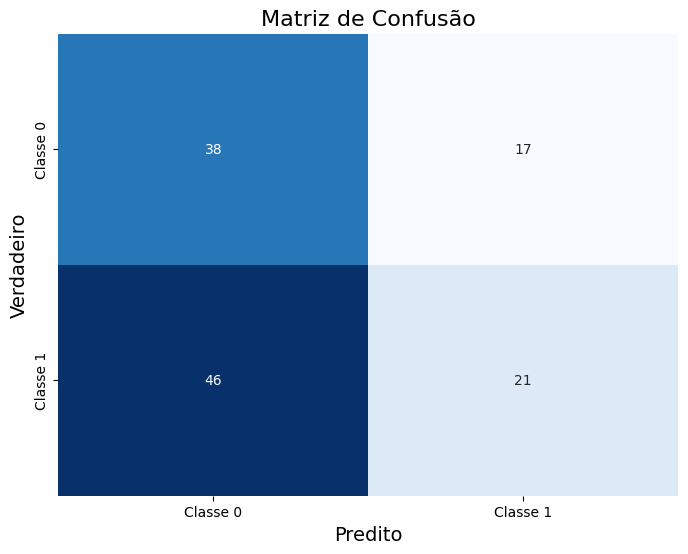

In [27]:
plot_confusion_matrix(y_petr4_test, y_pred)

### Diagnóstico

- Underfitting:  Não deve ter ocorrido muito. Obtivemos (f1-score=0.5495 | accuracy=0.5542) no KFold, o que está relativamente próximo à resultados de trabalhos da litetura de predição do movimento de ações

- Overfitting: Não ocorreu. O modelo está com resultados até melhores no conjunto de teste em relação ao conjunto de treino.


O diagnóstico final é que o principal fenômeno ocorrido foi a sorte no conjutno de teste, e que o modelo está com um leve **underfitting**.

- Para evitar o problema do modelo ter sorte no conjunto de teste, poderíamos:
    - Aumentar o tamanho do conjunto de teste. Porém, não é algo que é possível fazer no momento.

- Para reduzir o underfitting, poderíamos:
    - Inserir mais features
    - *Mudança no espaço de busca de hiperparâmetros*: Modificar o espaço de busca para hiperparâmetros que tornem o modelo **mais complexo**

Como não houve muito underfitting e não podemos fazer muito quanto a aumentar o tamanho do conjunto de dados de teste, resolvemos concentrar esforços nos outros modelos.

## PETR4

Observando a quantidade de eventos no conjunto de treino/validação e teste. Podemos concluir que os modelos, por serem treinados com um dataset levemente desbalanceado, possuem maior viés para indicar a predição positiva `hasRise=1`, devido que, em geral, 

In [28]:
y_petr4_train.value_counts(normalize=True)

hasRise
1    0.541114
0    0.458886
Name: proportion, dtype: float64

In [29]:
y_petr4_test.value_counts(normalize=True)

hasRise
1    0.54918
0    0.45082
Name: proportion, dtype: float64

In [30]:
def objective(trial):
    # Definir o espaço de busca dos hiperparâmetros
    param = {
        'solver': 'liblinear',
        'random_state': RANDOM_SEED,
        'C': trial.suggest_float('C', 1e-4, 1e2, log=True), # INVERSO do termo de regularização
        'tol': trial.suggest_float('tol', 1e-6, 1e-1, log=True),
        'penalty' : trial.suggest_categorical('penalty', ['l1', 'l2'])
    }
    
    # Configurando o KFold
    kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    
    # Inicializando o modelo XGBoost
    model = LogisticRegression(**param)
    
    # Realizando a validação cruzada
    scores = cross_val_score(model, X_petr4_train, y_petr4_train, cv=kf, scoring='accuracy')
    
    # Retornando a média dos scores como objetivo a ser minimizado
    return np.mean(scores)

In [31]:
mlflow.set_experiment("Logistic Regression PETR4")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=300, callbacks=[mlflow_callback])


2024/07/11 19:04:36 INFO mlflow.tracking.fluent: Experiment with name 'Logistic Regression PETR4' does not exist. Creating a new experiment.
[I 2024-07-11 19:04:36,045] A new study created in memory with name: no-name-43855876-2948-472d-9828-e9c8558089c6
[I 2024-07-11 19:04:36,238] Trial 0 finished with value: 0.5519999999999999 and parameters: {'C': 40.758813424837314, 'tol': 0.00028224590707688364, 'penalty': 'l1'}. Best is trial 0 with value: 0.5519999999999999.
[I 2024-07-11 19:04:36,262] Trial 1 finished with value: 0.5225263157894736 and parameters: {'C': 0.004975991319972616, 'tol': 0.00018863002127169707, 'penalty': 'l2'}. Best is trial 0 with value: 0.5519999999999999.
[I 2024-07-11 19:04:36,285] Trial 2 finished with value: 0.5305964912280702 and parameters: {'C': 0.019419833700803395, 'tol': 6.675905961827798e-05, 'penalty': 'l2'}. Best is trial 0 with value: 0.5519999999999999.
[I 2024-07-11 19:04:36,327] Trial 3 finished with value: 0.5785263157894737 and parameters: {'C':

### Avaliação 

In [32]:
study.best_params


{'C': 0.97294101649907, 'tol': 1.0539563277175033e-06, 'penalty': 'l2'}

In [8]:
best_params = {'random_state': RANDOM_SEED, 'solver': 'liblinear', 'C': 0.97294101649907, 'tol': 1.0539563277175033e-06, 'penalty': 'l2'}
model = LogisticRegression(**best_params)

# Treinando o modelo no conjunto de treinamento completo
model = model.fit(X_petr4_train, y_petr4_train)

In [11]:
calculo_lucro(model, df_vale3_test, X_vale3_test, acao='VALE3')

[*********************100%%**********************]  1 of 1 completed

Retorno: -8.88%


Exibindo os resultados do KFold no conjunto de treino para termos uma referência:

In [36]:
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
f1_kfold_scores = cross_val_score(model, X_petr4_train, y_petr4_train, cv=kf, scoring='f1').mean()
accuracy_kfold_scores = cross_val_score(model, X_petr4_train, y_petr4_train, cv=kf, scoring='accuracy').mean()

print(f'[TRAINING SET KFOLD] The model scored a mean of: f1-score={f1_kfold_scores:.4f} | accuracy={accuracy_kfold_scores:.4f}')

[TRAINING SET KFOLD] The model scored a mean of: f1-score=0.6293 | accuracy=0.5891


Resultados para o conjunto de teste:

In [37]:
# Avaliando o modelo
y_pred = model.predict(X_petr4_test)
report = classification_report(y_petr4_test, y_pred, digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.4522    0.9455    0.6118        55
           1     0.5714    0.0597    0.1081        67

    accuracy                         0.4590       122
   macro avg     0.5118    0.5026    0.3599       122
weighted avg     0.5177    0.4590    0.3352       122



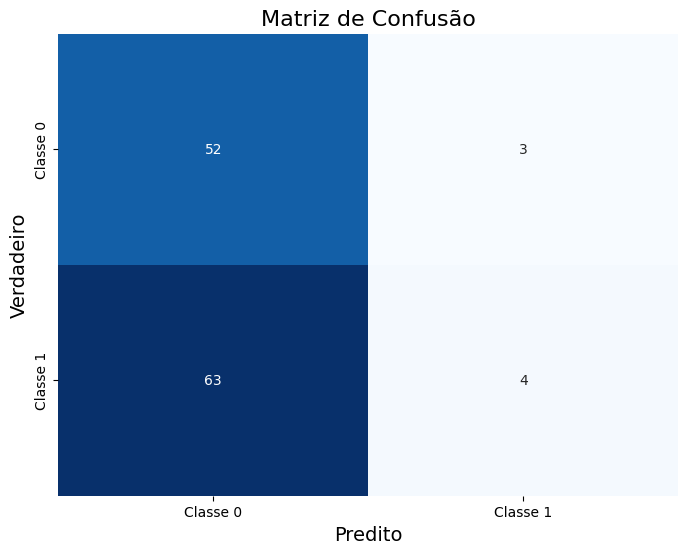

In [38]:
plot_confusion_matrix(y_petr4_test, y_pred)

### Diagnóstico

f1-score=0.6293 | accuracy=0.5891

Podemos diagnosticar o modelo com **overfitting**, visto que os resultados no conjunto de treino (58,91% de acurácia, 0.6293 de F1-Score) estão significativamente superiores aos resultados do conjunto de teste (45,90% de acurácia, 0.1081 de F1-Score)

Após diagnosticar o problema de **overfitting**, podemos tentar melhorar o modelo tomando medidas como:
- *Reduzir features utilizadas*
- *Utilizar modelos mais simples*
- *Aumentar o tamanho do conjunto de treinamento*
- *Mudança no espaço de busca de hiperparâmetros*: Adicionar hiperparâmetros de regularização ou restringir o espaço de busca para hiperparâmetros que tornem o modelo menos complexo

#### Tentativa 1 de melhorar o modelo

##### - *Reduzir features utilizadas*: Removendo features com alta correlação

In [39]:
def get_highly_correlated_features(correlation_matrix, threshold):
  correlated_pairs = []
  for i in range(len(correlation_matrix.columns)):
    for j in range(i):
      if abs(correlation_matrix.iloc[i, j]) > threshold:
        pair = (correlation_matrix.columns[i], correlation_matrix.columns[j])
        coefficient = correlation_matrix.iloc[i, j]
        correlated_pairs.append((pair, coefficient))
  return sorted(correlated_pairs, key= lambda pair: pair[1], reverse=True)

MAX_CORRELATION = 0.90

corr_matrix = X_petr4_train.corr(method='spearman').abs()
correlation_list = get_highly_correlated_features(corr_matrix, MAX_CORRELATION)
len(correlation_list), correlation_list[:10]


(53,
 [(('bom negócio_count', 'valorização_count'), 1.0),
  (('lucro_count', 'valorização_count'), 1.0),
  (('lucro_count', 'bom negócio_count'), 1.0),
  (('neutro_count', 'valorização_count'), 1.0),
  (('neutro_count', 'bom negócio_count'), 1.0),
  (('neutro_count', 'lucro_count'), 1.0),
  (('desvalorização_count', 'valorização_count'), 1.0),
  (('desvalorização_count', 'bom negócio_count'), 1.0),
  (('desvalorização_count', 'lucro_count'), 1.0),
  (('desvalorização_count', 'neutro_count'), 1.0)])

Temos 53 PARES features com correlação maior que 0.95! Vamos remover um dos elementos dos pares para reduzir essa redundância

In [40]:
# Drop high correlated features in correlation list

f2drop = []
for feature_pair, _ in correlation_list:
  if feature_pair[0] not in f2drop and feature_pair[1] not in f2drop:
    f2drop.append(feature_pair[1])

X_petr4_train_reduced = X_petr4_train.drop(f2drop, axis='columns')
X_petr4_test_reduced = X_petr4_test.drop(f2drop, axis='columns')

In [41]:
X_petr4_train.shape, X_petr4_train_reduced.shape 

((377, 62), (377, 38))

##### - *Mudança no espaço de busca de hiperparâmetros*: Adicionar hiperparâmetros de regularização ou restringir o espaço de busca para hiperparâmetros que tornem o modelo menos complexo

In [42]:
def objective_xgboost(trial):
    # Definir o espaço de busca dos hiperparâmetros
    param = {
        'solver': 'liblinear',
        'random_state': RANDOM_SEED,
        'C': trial.suggest_float('C', 1e-6, 1e-1, log=True), # INVERSO do termo de regularização
        'tol': trial.suggest_float('tol', 1e-6, 1e-1, log=True),
        'penalty' : trial.suggest_categorical('penalty', ['l1', 'l2'])
    }
    
    # Configurando o KFold
    kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    
    # Inicializando o modelo XGBoost
    model = LogisticRegression(**param)
    
    # Realizando a validação cruzada
    scores = cross_val_score(model, X_petr4_train_reduced, y_petr4_train, cv=kf, scoring='accuracy')
    
    # Retornando a média dos scores como objetivo a ser minimizado
    return np.mean(scores)

In [43]:
mlflow.set_experiment("Logistic Regression PETR4 Trial 2")
study = optuna.create_study(direction='maximize')
study.optimize(objective_xgboost, n_trials=300, callbacks=[mlflow_callback])


2024/07/11 19:12:17 INFO mlflow.tracking.fluent: Experiment with name 'Logistic Regression PETR4 Trial 2' does not exist. Creating a new experiment.
[I 2024-07-11 19:12:17,182] A new study created in memory with name: no-name-fef517b0-aed5-4ae3-879c-41c8552a7d75
[I 2024-07-11 19:12:17,197] Trial 0 finished with value: 0.4591578947368421 and parameters: {'C': 1.1151742129160417e-05, 'tol': 0.006882021293224991, 'penalty': 'l1'}. Best is trial 0 with value: 0.4591578947368421.
[I 2024-07-11 19:12:17,229] Trial 1 finished with value: 0.5252280701754386 and parameters: {'C': 0.01871635386051379, 'tol': 1.5756855297080596e-05, 'penalty': 'l2'}. Best is trial 1 with value: 0.5252280701754386.
[I 2024-07-11 19:12:17,258] Trial 2 finished with value: 0.5196842105263157 and parameters: {'C': 0.062107952210244094, 'tol': 0.01930040525762339, 'penalty': 'l1'}. Best is trial 1 with value: 0.5252280701754386.
[I 2024-07-11 19:12:17,290] Trial 3 finished with value: 0.5251578947368422 and parameters

##### Avaliação 

In [45]:
study.best_params


{'C': 0.09500564917682214, 'tol': 0.001962864133608186, 'penalty': 'l2'}

In [46]:
best_params = {'random_state': RANDOM_SEED, 'solver': 'liblinear', 'C': 0.09500564917682214, 'tol': 0.001962864133608186, 'penalty': 'l2'}

model = LogisticRegression(**best_params)

# Treinando o modelo no conjunto de treinamento completo
model = model.fit(X_petr4_train_reduced, y_petr4_train)

Exibindo os resultados do KFold no conjunto de treino para termos uma referência:

In [47]:
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
f1_kfold_scores = cross_val_score(model, X_petr4_train_reduced, y_petr4_train, cv=kf, scoring='f1').mean()
accuracy_kfold_scores = cross_val_score(model, X_petr4_train_reduced, y_petr4_train, cv=kf, scoring='accuracy').mean()

print(f'[TRAINING SET KFOLD] The model scored a mean of: f1-score={f1_kfold_scores:.4f} | accuracy={accuracy_kfold_scores:.4f}')

[TRAINING SET KFOLD] The model scored a mean of: f1-score=0.5990 | accuracy=0.5519


Resultados para o conjunto de teste:

In [48]:
# Avaliando o modelo
y_pred = model.predict(X_petr4_test_reduced)
report = classification_report(y_petr4_test, y_pred, digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.4404    0.8727    0.5854        55
           1     0.4615    0.0896    0.1500        67

    accuracy                         0.4426       122
   macro avg     0.4510    0.4811    0.3677       122
weighted avg     0.4520    0.4426    0.3463       122



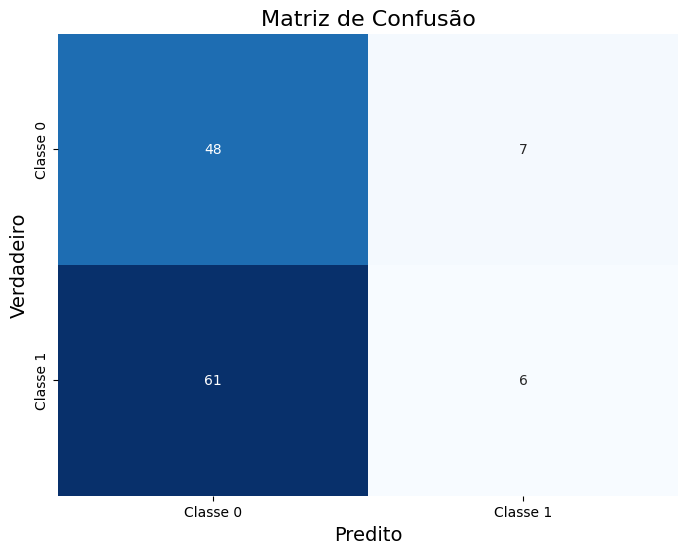

In [49]:
plot_confusion_matrix(y_petr4_test, y_pred)

Os resultados não melhoraram :(
    
O overfitting aparenta ainda permanecer forte. Vamos fazer um experimento: incluir mais dados no conjunto de treino para verificar como o resultado se comporta. Visto que ainda estamos tratando de um problema de overfitting, é esperado que os resultados melhorem

#### Tentativa 2 de melhorar o modelo

Vamos fazer um experimento: incluir mais dados no conjunto de treino para verificar como o resultado se comporta. Visto que ainda estamos tratando de um problema de overfitting, é esperado que os resultados melhorem

In [50]:
df_petr4_test = df_petr4_test.set_index('Date')

In [51]:
CUTOFF_DATE = '2024-03-01'

df_petr4_test_until_2023_03_01 = df_petr4_test[:CUTOFF_DATE].reset_index()
df_petr4_test_from_2023_03_01 = df_petr4_test[CUTOFF_DATE:].reset_index()


In [52]:
df_petr4_train_until_2023_03_01 = pd.concat([df_petr4_train, df_petr4_test_until_2023_03_01], ignore_index=True)

In [53]:
X_petr4_train_until_2023_03_01 = df_petr4_train_until_2023_03_01.drop(['hasRise', 'Date'], axis='columns')
y_petr4_train_until_2023_03_01 = df_petr4_train_until_2023_03_01['hasRise']

X_petr4_test_from_2023_03_01 = df_petr4_test_from_2023_03_01.drop(['hasRise', 'Date'], axis='columns')
y_petr4_test_from_2023_03_01 = df_petr4_test_from_2023_03_01['hasRise']

In [54]:
(X_petr4_train_until_2023_03_01.shape, y_petr4_train_until_2023_03_01.shape), \
(X_petr4_test_from_2023_03_01.shape, y_petr4_test_from_2023_03_01.shape)

(((438, 62), (438,)), ((62, 62), (62,)))

Utilizando técnicas da Tentativa 1:

In [55]:
# Dropping highly correlated columns
X_petr4_train_until_2023_03_01_reduced = X_petr4_train_until_2023_03_01.drop(f2drop, axis='columns')
X_petr4_test_from_2023_03_01_reduced = X_petr4_test_from_2023_03_01.drop(f2drop, axis='columns')

In [56]:
# Usando espaço de busca de parâmetros focado em modelos mais simples, que tende a reduzir overfitting

def objective_xgboost(trial):
    # Definir o espaço de busca dos hiperparâmetros
    param = {
        'solver': 'liblinear',
        'random_state': RANDOM_SEED,
        'C': trial.suggest_float('C', 1e-6, 1e-1, log=True), # INVERSO do termo de regularização
        'tol': trial.suggest_float('tol', 1e-6, 1e-1, log=True),
        'penalty' : trial.suggest_categorical('penalty', ['l1', 'l2'])
    }
    
    # Configurando o KFold
    kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    
    # Inicializando o modelo XGBoost
    model = LogisticRegression(**param)
    
    # Realizando a validação cruzada
    scores = cross_val_score(model, X_petr4_train_until_2023_03_01_reduced, y_petr4_train_until_2023_03_01, cv=kf, scoring='accuracy')
    
    # Retornando a média dos scores como objetivo a ser minimizado
    return np.mean(scores)

In [57]:
mlflow.set_experiment("Logistic Regression PETR4 Trial 3")
study = optuna.create_study(direction='maximize')
study.optimize(objective_xgboost, n_trials=300, callbacks=[mlflow_callback])

2024/07/11 19:15:05 INFO mlflow.tracking.fluent: Experiment with name 'Logistic Regression PETR4 Trial 3' does not exist. Creating a new experiment.
[I 2024-07-11 19:15:05,687] A new study created in memory with name: no-name-38a45837-bc88-45a7-8bdc-98c40ba1a942
[I 2024-07-11 19:15:05,703] Trial 0 finished with value: 0.45906478578892373 and parameters: {'C': 0.0018034215657202807, 'tol': 0.00469854968021973, 'penalty': 'l1'}. Best is trial 0 with value: 0.45906478578892373.
[I 2024-07-11 19:15:05,730] Trial 1 finished with value: 0.5318443051201671 and parameters: {'C': 1.2234108059192064e-06, 'tol': 5.440634351096359e-06, 'penalty': 'l2'}. Best is trial 1 with value: 0.5318443051201671.
[I 2024-07-11 19:15:05,760] Trial 2 finished with value: 0.5364158829676071 and parameters: {'C': 8.554419301711155e-05, 'tol': 4.67453586936177e-06, 'penalty': 'l2'}. Best is trial 2 with value: 0.5364158829676071.
[I 2024-07-11 19:15:05,789] Trial 3 finished with value: 0.45906478578892373 and param

##### Avaliação 

In [59]:
best_params = {'random_state': RANDOM_SEED, 'solver': 'liblinear', 'C': 0.0004202195565893979, 'tol': 1.0056135062917044e-05, 'penalty': 'l2'}

model = LogisticRegression(**best_params)

# Treinando o modelo no conjunto de treinamento completo
model = model.fit(X_petr4_train_until_2023_03_01_reduced, y_petr4_train_until_2023_03_01)

Exibindo os resultados do KFold no conjunto de treino para termos uma referência:

In [60]:
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
f1_kfold_scores = cross_val_score(model, X_petr4_train_until_2023_03_01_reduced, y_petr4_train_until_2023_03_01, cv=kf, scoring='f1').mean()
accuracy_kfold_scores = cross_val_score(model, X_petr4_train_until_2023_03_01_reduced, y_petr4_train_until_2023_03_01, cv=kf, scoring='accuracy').mean()

print(f'[TRAINING SET KFOLD] The model scored a mean of: f1-score={f1_kfold_scores:.4f} | accuracy={accuracy_kfold_scores:.4f}')

[TRAINING SET KFOLD] The model scored a mean of: f1-score=0.5928 | accuracy=0.5409


Resultados para o conjunto de teste:

In [61]:
# Avaliando o modelo
y_pred = model.predict(X_petr4_test_from_2023_03_01_reduced)
report = classification_report(y_petr4_test_from_2023_03_01, y_pred, digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.5357    0.5357    0.5357        28
           1     0.6176    0.6176    0.6176        34

    accuracy                         0.5806        62
   macro avg     0.5767    0.5767    0.5767        62
weighted avg     0.5806    0.5806    0.5806        62



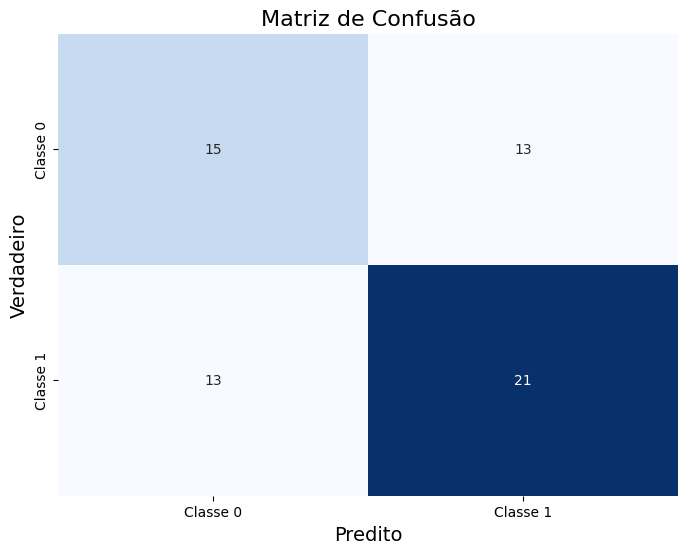

In [62]:
plot_confusion_matrix(y_petr4_test_from_2023_03_01, y_pred)

Reduzimos overfitting com sucesso! Agora temos os seguinte resultados:
- Treino: f1-score=0.5928 | accuracy=0.5409
- Teste: f1-score=0.6176 | accuracy=0.5806

Que nos permitem concluir que overfitting não está acontecendo, visto que os resultados do treino/validação e teste estão próximos.


Porém, uma observação relevante é que o modelo provavelmente deu sorte ao realizar suas predições, devido ao resultado no conjunto de teste ter sido maior do que no de treino/validação